In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg

Here's a function to construct the 5-point Laplacian finite difference formula  
$$\frac{1}{h^2}\left(U_{i-1,j}+U_{i+1,j}+U_{i,j-1}+U_{i,j+1}-4U_{ij}\right)$$  
as a matrix $A$, so that the product $AU$ gives the formula above when $U$ is constructed using  
the natural row-wise ordering:  

In [2]:
def five_pt_laplacian(m):
    e=np.ones(m**2)
    e2=([0]+[1]*(m-1))*m
    h=1./(m+1)
    A=np.diag(-4*e,0)+np.diag(e2[1:],-1)+np.diag(e2[1:],1)+np.diag(e[m:],m)+np.diag(e[m:],-m)
    A/=h**2
    return A

Matplotlib has a nice spy() command, just like MATLAB's, which shows us  the structure of $A$ (note here the structure of the +1 and -1  diagonals):  

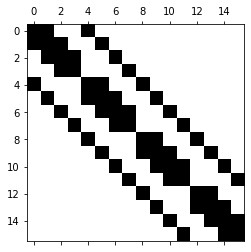

In [3]:
A=five_pt_laplacian(4)
plt.spy(A)

Notice that each row has at most 5 non-zero entries, and at least $m^2-5$ entries equal to zero. The function above constructs a full matrix, meaning all those zeros are stored in memory. This will take up a lot of memory! We might as well just store the non-zero entries. This is done with the following code (take a look at the help for spdiags):  

In [4]:
def five_pt_laplacian_sparse(m):
    e=np.ones(m**2)
    e2=([1]*(m-1)+[0])*m
    e3=([0]+[1]*(m-1))*m
    h=1./(m+1)
    A=spdiags([-4*e,e2,e3,e,e],[0,-1,1,-m,m],m**2,m**2)
    A/=h**2
    return A

Another tool we need is a way to transform a matrix whose $i,j$ entry corresponds to the point $x_i,y_j$ on the grid into a vector using the natural row-wise ordering. Like MATLAB, numpy has a reshape() command that does just this:  

In [5]:
U=np.array([[1,2,3],[4,5,6],[7,8,9]])
print(U)
print(U.reshape([9]))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[1 2 3 4 5 6 7 8 9]


Now let's solve the 2D BVP  

$$\nabla^2 u = -(20y^3+9\pi^2(y-y^5))\sin(3\pi x)$$  

on the unit square $[0,1]\times[0,1]$ with homogeneous Dirichlet boundary conditions (i.e., $u(x,y)=0$ everywhere on the boundary):  

In [6]:
# Define the RHS function:
f = lambda x,y: -(20*y**3+9*np.pi**2*(y-y**5.))*np.sin(3*np.pi*x)
#Set up the grid:
m=100
x=np.linspace(0,1,m+2); x=x[1:-1]
y=np.linspace(0,1,m+2); y=y[1:-1]
X,Y=np.meshgrid(x,y)
#Set up and solve the linear system
A=five_pt_laplacian_sparse(m).tocsr()
F=f(X,Y).reshape([m**2])
U=linalg.spsolve(A,F)

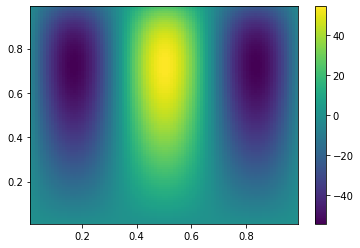

In [7]:
plt.pcolor(X,Y,f(X,Y));
plt.colorbar();

In order to plot the solution, we reshape $U$ to be the shape of the grid:  

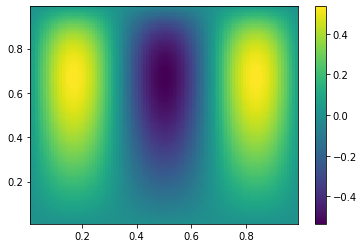

In [8]:
U=U.reshape([m,m])
plt.pcolor(X,Y,U)
plt.colorbar();

How accurate is this solution? Try plotting the difference between the computed and exact values.  
Now let's plot the exact solution. In fact, the problem above was obtained by taking  
$$u(x,y) = (y-y^5)\sin(3\pi x)$$  
and taking the Laplacian of $u$. Notice that $u=0$ on the boundaries.  

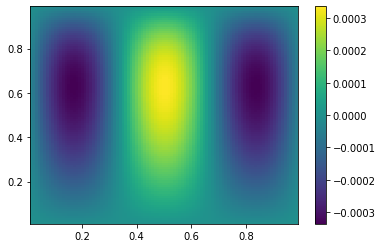

In [9]:
U_exact=[]
U_exact=(Y-Y**5)*np.sin(3*np.pi*X)
plt.clf()
plt.pcolor(X,Y,U_exact-U)
plt.colorbar()

## Kronecker product approach

In [10]:
def laplacian_1D(m):
    em = np.ones(m)
    e1=np.ones(m-1)
    return (np.diag(-2*em,0)+np.diag(e1,-1)+np.diag(e1,1))*(m+1)**2

In [11]:
def laplacian_2D(m):
    I = np.eye(m)
    A = laplacian_1D(m)
    return np.kron(A,I) + np.kron(I,A)

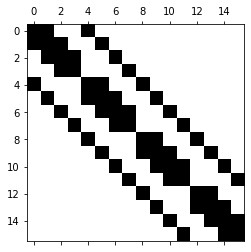

In [12]:
plt.spy(laplacian_2D(4));

In [13]:
print(laplacian_2D(3))

[[-64.  16.   0.  16.   0.   0.   0.   0.   0.]
 [ 16. -64.  16.   0.  16.   0.   0.   0.   0.]
 [  0.  16. -64.   0.   0.  16.   0.   0.   0.]
 [ 16.   0.   0. -64.  16.   0.  16.   0.   0.]
 [  0.  16.   0.  16. -64.  16.   0.  16.   0.]
 [  0.   0.  16.   0.  16. -64.   0.   0.  16.]
 [  0.   0.   0.  16.   0.   0. -64.  16.   0.]
 [  0.   0.   0.   0.  16.   0.  16. -64.  16.]
 [  0.   0.   0.   0.   0.  16.   0.  16. -64.]]
